# **How to Use Riveter** 💪

This Jupyter notebook will demonstrate how to use the Riveter package to measure social dynamics between personas mentioned in a collection of texts.

The package identifies and extracts the subjects, verbs, and direct objects in texts; it performs coreference resolution on the personas mentioned in the texts (e.g., clustering "Elizabeth Bennet" and "she" together as one persona); and it measures social dynamics between the personas by referencing a given lexicon. The package currently includes Maarten Sap et al's lexicon for power and agency and Rashkin et al's lexicon for perspective, effect, value, and mental state. 

<br><br><br><br>

## **Import libraries**

In [1]:
import os
import pandas as pd
import random
from riveter import Riveter

import seaborn as sns
import matplotlib.pyplot as plt

<br><br><br><br>

## **Small demo with Sap et al's Power and Agency Lexicon**

Here are three example stories that we will use to measure power and agency between personas:
> 1. I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.

> 2. My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too.

> 3. She went to the store. She thanked the doctor.

In [22]:
example_stories = ["I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.",
                   "My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too.",
                   "She went to the store. She thanked the doctor."]
text_ids = [0, 1, 2]

<br><br>

### Load lexicon ("power") and train model

In [3]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(example_stories,
              text_ids)

100%|██████████| 3/3 [00:00<00:00, 31.65it/s]

2023-05-25 15:03:15 Complete!


### Get total scores for all documents

You can use the `.get_score_totals()` function to get cumulative power scores (or chosen dynamic scores) for each persona mentioned in the texts.

In [4]:
riveter.get_score_totals(frequency_threshold=1)

{'i': -0.5,
 'my doctor': 1.0,
 'my friend': 0.5,
 'susan': -0.5,
 'the doctor': 1.0}

We can see all the contributing verbs for each persona and whether they contributed positively or negatively.

In [5]:
riveter.get_persona_polarity_verb_count_dict()

{'i': defaultdict(<function riveter.default_dict_int()>,
             {'negative': defaultdict(int,
                          {'call_nsubj': 1,
                           'pick_dobj': 1,
                           'thank_nsubj': 1})}),
 'my doctor': defaultdict(<function riveter.default_dict_int()>,
             {'positive': defaultdict(int,
                          {'call_dobj': 2, 'fix_nsubj': 1, 'thank_dobj': 1})}),
 'my friend': defaultdict(<function riveter.default_dict_int()>,
             {'positive': defaultdict(int, {'call_dobj': 1})}),
 'susan': defaultdict(<function riveter.default_dict_int()>,
             {'negative': defaultdict(int, {'call_nsubj': 1})}),
 'the doctor': defaultdict(<function riveter.default_dict_int()>,
             {'positive': defaultdict(int, {'thank_dobj': 1})})}

And we can view these scores visually for each persona. 

In the following heatmap, each cell contains the count of matching verbs for the persona that contributed either positively or negatively to its final score. 

(See examples later in the notebook for entities with more verbs). 

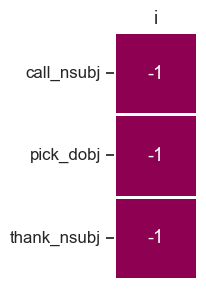

In [6]:
riveter.plot_verbs_for_persona('i', figsize=(2, 4))

We can save the Riveter object for later, and reload it when we want to use it again.

In [7]:
riveter.save('test')

Riveter successfully saved to "test"


You can also see what words or names have been clustered together for each persona (performed by the coreference resolution model).

In [8]:
riveter.get_persona_cluster('my doctor')

{'my doctor': 2, 'him': 1, 'the doctor': 1}

In [9]:
riveter.get_persona_cluster('susan')

{'susan': 1, 'she': 1}

In [10]:
riveter.get_persona_cluster('i')

{'i': 5, 'me': 1}

### Plot scores for all documents

You can use the `.plot_scores()` function to display a bar plot with the top *n* or bottom *n* personas in the texts. The function will display the top 10 highest-scoring personas by default.

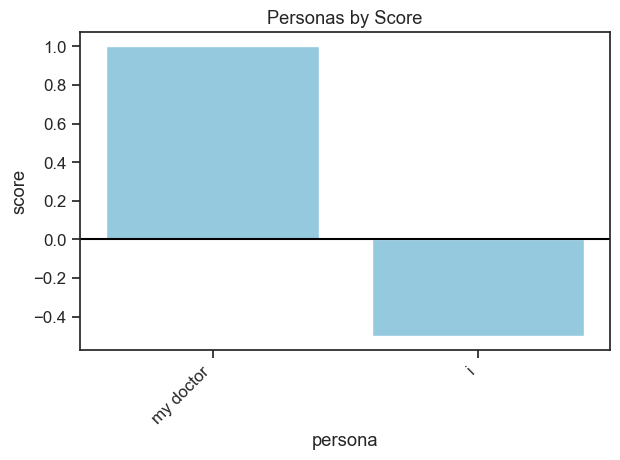

In [11]:
riveter.plot_scores(frequency_threshold=2)

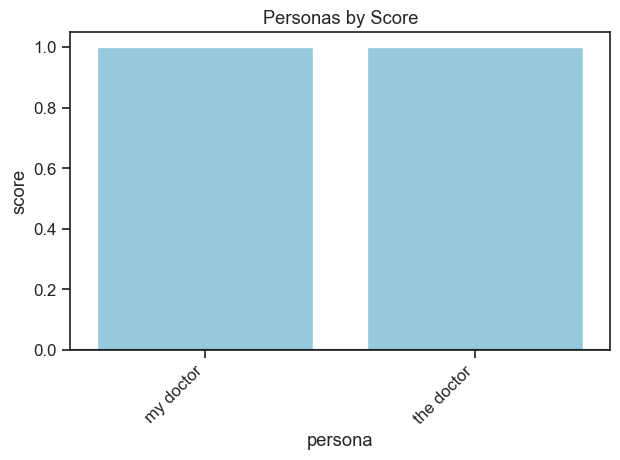

In [12]:
riveter.plot_scores(2)

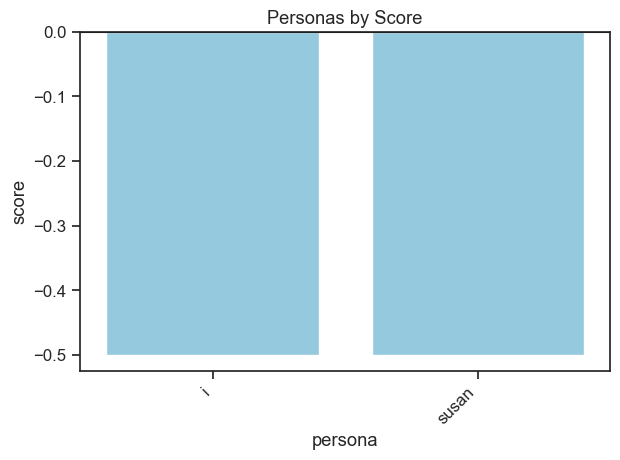

In [13]:
riveter.plot_scores(-2)

### Get scores, subjects, and direct objects for each document

You can use the `.get_score_for_doc()` function to get power scores (or chosen dynamic scores) for each persona mentioned in a document (based on the document id passed into the training function).

In [14]:
example_stories[0]

'I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.'

In [15]:
riveter.get_scores_for_doc(0)

{'i': -0.4, 'my friend': 0.5, 'my doctor': 1.0}

You can use `.count_nsubj_for_doc()` to get all noun subjects and verb pairs (regardless of whether the verb apperas in the chosen lexicon) for each document.

In [16]:
riveter.count_nsubj_for_doc(0)

{('my friend', 'be'): 1,
 ('i', 'think'): 1,
 ('i', 'have'): 1,
 ('i', 'feel'): 1,
 ('i', 'call'): 1}

You can use `.count_dobj_for_doc()` to get all direct objects and verb pairs (regardless of whether the verb apperas in the chosen lexicon) for each document.

In [17]:
riveter.count_dobj_for_doc(0)

{('my friend', 'call'): 1, ('my doctor', 'call'): 1, ('i', 'pick'): 1}

### Plot scores for each document

You can use the `.plot_scores_for_doc()` function to display a bar plot with the top *n* or bottom *n* personas in a specified document. The function will display the top 10 highest-scoring personas by default.

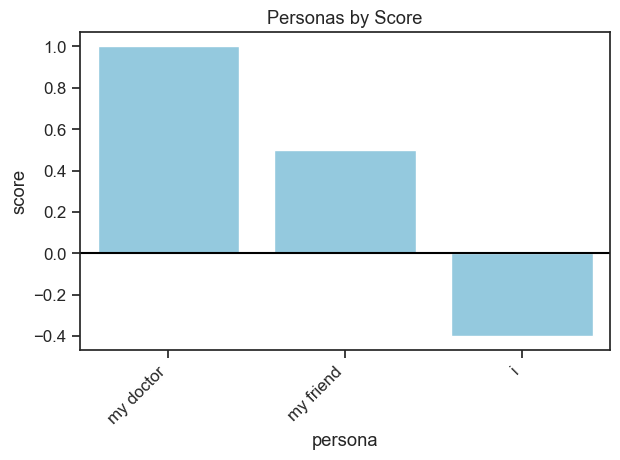

In [18]:
riveter.plot_scores_for_doc(0)

### Use regular expressions in place of entity extraction and coreference resolution

Instead of discovering all the entities automatically, you can define a regular expression to capture patterns for each entity. You will need to determine these entities and patterns yourself.

In [19]:
riveter.train(example_stories,
              text_ids,
              persona_patterns_dict={'first person singular': r'^i$|^me$'})

100%|██████████| 3/3 [00:00<00:00, 44.28it/s]

2023-05-25 13:36:59 Complete!


In [20]:
riveter.get_score_totals()

{'first person singular': -0.5}

### Use agency lexicon instead of power

In [21]:
riveter = Riveter()
riveter.load_sap_lexicon('agency')
riveter.train(example_stories,
              text_ids)

100%|██████████| 3/3 [00:00<00:00, 42.49it/s]

2023-05-25 13:37:01 Complete!


In [22]:
riveter.get_score_totals()

{'i': 0.5,
 'my doctor': 0.25,
 'my friend': 0.0,
 'susan': 0.5,
 'the doctor': 0.0}

<br><br><br><br>

## **Small demo w/ Rashkin frames**

This example is similar to the first example, but here, we'll use Rashkin et al's sentiment frames instead of the power and agency frames we used above.

In [6]:
example_stories = ["I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.",
                   "My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too."]
text_ids = [0, 1]

In [7]:
riveter = Riveter()
riveter.load_rashkin_lexicon('effect')
riveter.train(example_stories,
              text_ids)

100%|██████████| 2/2 [00:00<00:00, 29.17it/s]

2023-05-25 15:03:24 Complete!


In [8]:
riveter.get_score_totals()

{'i': 0.34444444444450006,
 'my doctor': 0.35,
 'my friend': 0.1333333333335,
 'susan': 0.16666666666649999}

In [9]:
riveter.get_scores_for_doc(0)

{'i': 0.28, 'my doctor': 0.266666666667, 'my friend': 0.1333333333335}

In [10]:
riveter.get_scores_for_doc(1)

{'i': 0.666666666667,
 'my doctor': 0.3777777777776667,
 'susan': 0.16666666666649999}

In [11]:
riveter = Riveter()
riveter.load_rashkin_lexicon('value')
riveter.train(example_stories,
              text_ids)

100%|██████████| 2/2 [00:00<00:00, 31.80it/s]

2023-05-25 15:03:27 Complete!


In [12]:
riveter.get_score_totals()

{'i': 0.6444444444445,
 'my doctor': 0.8000000000002501,
 'my friend': 0.4333333333335,
 'susan': 0.5333333333335}

<br><br><br><br>

## **Small demo w/ custom frames**

This example is similar to the first example, but here, we'll use a custom lexicon. You can follow this pattern to use your own lexicon.

(In this case, our "custom lexicon" is actually just a copy of the Rashkin lexicon.)

In [13]:
example_stories = ["I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.",
                   "My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too."]
text_ids = [0, 1]

In [14]:
riveter = Riveter()
riveter.load_custom_lexicon(lexicon_path='data/example-custom-lexicon/full_frame_info.tsv', 
                            verb_column='verb',
                            agent_column='effect(a)',
                            theme_column='effect(t)')
riveter.train(example_stories,
              text_ids)

100%|██████████| 2/2 [00:00<00:00, 32.64it/s]

2023-05-25 15:03:28 Complete!


In [15]:
riveter.get_score_totals()

{'i': 0.34444444444450006,
 'my friend': 0.1333333333335,
 'my doctor': 0.35,
 'susan': 0.16666666666649999}

In [16]:
riveter.get_scores_for_doc(0)

{'i': 0.28, 'my friend': 0.1333333333335, 'my doctor': 0.266666666667}

In [17]:
riveter.get_scores_for_doc(1)

{'my doctor': 0.3777777777776667,
 'susan': 0.16666666666649999,
 'i': 0.666666666667}

In [18]:
riveter = Riveter()
riveter.load_rashkin_lexicon('value')
riveter.train(example_stories,
              text_ids)

100%|██████████| 2/2 [00:00<00:00, 33.09it/s]

2023-05-25 15:03:30 Complete!


In [19]:
riveter.get_score_totals()

{'i': 0.6444444444445,
 'my doctor': 0.8000000000002501,
 'my friend': 0.4333333333335,
 'susan': 0.5333333333335}

<br><br><br><br>

## **Bigger demo w/ Sap frames for _Pride and Prejudice_**

Here we show a larger, more realistic example for the Jane Austen novel. 

We'll try both discovering entities automatically and using regular expressions to capture pronoun groups.

### Load data

In [3]:
texts = [_line.strip() for _line in open('data/pride_and_prejudice.txt', 'r') if _line.strip()]
text_ids = [i for i, t in enumerate(texts)]

len(texts), len(text_ids)

(11058, 11058)

### Explore using discovered entities (using entity recognition and coreference resolution)

In [3]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(texts,
              text_ids,
              num_bootstraps=10)

100%|██████████| 11058/11058 [01:43<00:00, 106.46it/s]


2023-05-25 21:25:45 Complete!


In [4]:
riveter.save('/Users/maria/Desktop/riveter.pride_and_prejudice.pkl')

Riveter successfully saved to "/Users/maria/Desktop/riveter.pride_and_prejudice.pkl"


In [5]:
persona_score_dict = riveter.get_score_totals(frequency_threshold=10)
len(persona_score_dict)

38

In [6]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True):
    print(round(_score, 2), '\t', _persona)

0.37 	 mr. gardiner
0.3 	 miss lucas
0.28 	 your sister
0.22 	 miss bingley
0.21 	 mrs. gardiner
0.2 	 sir william
0.18 	 mr. bennet
0.17 	 her sister
0.15 	 miss bennet
0.15 	 my father
0.15 	 kitty
0.14 	 lydia
0.12 	 darcy
0.12 	 mr. darcy
0.1 	 her aunt
0.1 	 you
0.09 	 lady catherine
0.09 	 lizzy
0.08 	 mr. collins
0.08 	 jane
0.08 	 mr. wickham
0.08 	 her father
0.06 	 mrs. bennet
0.06 	 elizabeth
0.05 	 wickham
0.04 	 colonel forster
0.03 	 mr. bingley
0.02 	 i
-0.01 	 mary
-0.01 	 her mother
-0.07 	 myself
-0.07 	 her husband
-0.08 	 charlotte
-0.12 	 your
-0.13 	 miss darcy
-0.13 	 bingley
-0.22 	 yourself
-0.88 	 her eyes


In [7]:
persona_polarity_verb_count_dict = riveter.get_persona_polarity_verb_count_dict()
len(persona_polarity_verb_count_dict)

522

In [8]:
persona_polarity_verb_count_dict['sir']

defaultdict(<function riveter.default_dict_int()>,
            {'positive': defaultdict(int,
                         {'do_nsubj': 1,
                          'assure_nsubj': 1,
                          'misunderstand_dobj': 1,
                          'thank_dobj': 1,
                          'satisfy_dobj': 1,
                          'know_nsubj': 2}),
             'negative': defaultdict(int, {'misunderstand_nsubj': 1})})

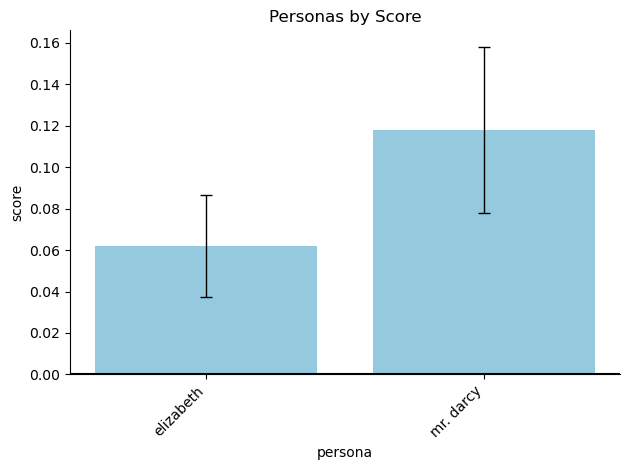

In [9]:
riveter.plot_scores(title='Personas by Score', target_personas=['elizabeth', 'mr. darcy'])

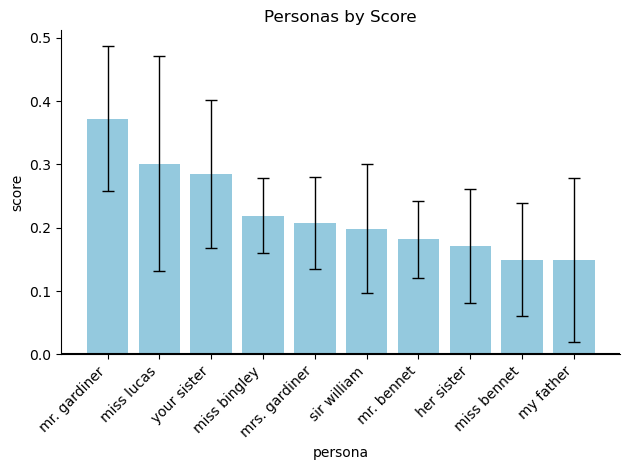

In [10]:
riveter.plot_scores(title='Personas by Score', frequency_threshold=10, number_of_scores=10)

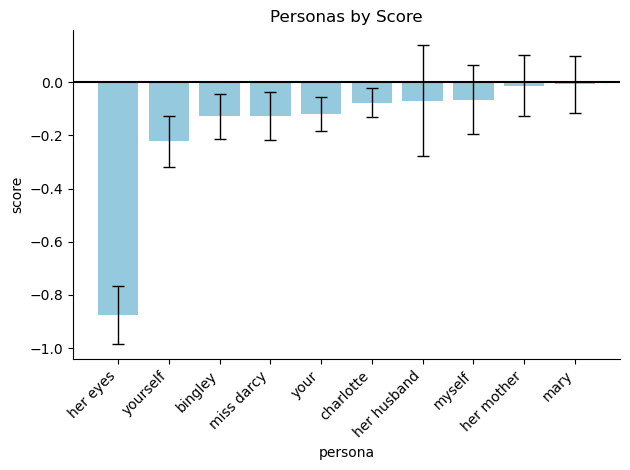

In [11]:
riveter.plot_scores(title='Personas by Score', frequency_threshold=10, number_of_scores=-10)

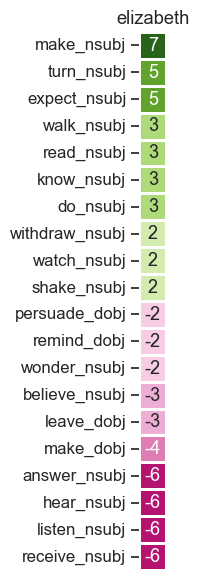

In [12]:
riveter.plot_verbs_for_persona('elizabeth', figsize=(2,6), output_path='/Users/maria/Desktop/heatmap.pride_and_prejudice.elizabeth.pdf')

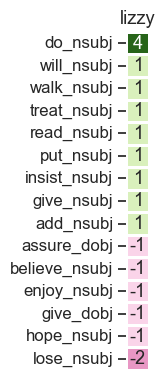

In [13]:
riveter.plot_verbs_for_persona('lizzy', figsize=(2,4), output_path='/Users/maria/Desktop/heatmap.pride_and_prejudice.lizzy.pdf')

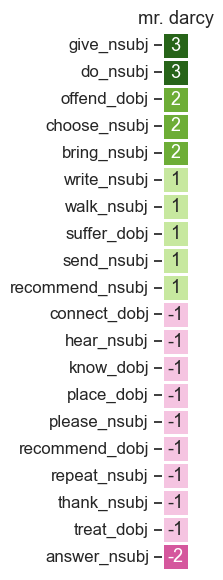

In [14]:
riveter.plot_verbs_for_persona('mr. darcy', figsize=(2,6), output_path='/Users/maria/Desktop/heatmap.pride_and_prejudice.mrdarcy.pdf')

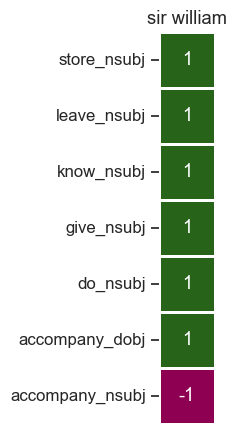

In [15]:
riveter.plot_verbs_for_persona('sir william', figsize=(2,6), output_path='/Users/maria/Desktop/heatmap.pride_and_prejudice.sirwilliam.pdf')

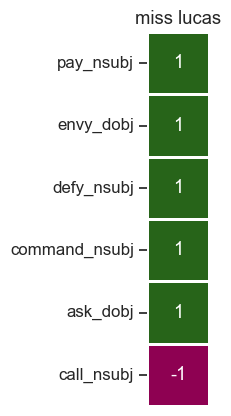

In [16]:
riveter.plot_verbs_for_persona('miss lucas', figsize=(2,6), output_path='/Users/maria/Desktop/heatmap.pride_and_prejudice.misslucas.pdf')

### Explore using regular expressions to capture pronouns

In [4]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(texts,
             text_ids,
             num_bootstraps=20,
             persona_patterns_dict={'masculine': r'^he$|^him$|^himself$',
                                    'feminine': r'^she$|^her$|^herself$',
                                    'third plural': r'^they$|^them$|^themselves$'})

100%|██████████| 11058/11058 [01:41<00:00, 109.01it/s]


2023-05-25 21:34:37 Complete!


In [5]:
persona_score_dict = riveter.get_score_totals()
len(persona_score_dict)

3

In [6]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True):
    print(round(_score, 3), '\t', _persona)

0.105 	 third plural
0.047 	 masculine
0.024 	 feminine


In [7]:
persona_polarity_verb_count_dict = riveter.get_persona_polarity_verb_count_dict()
len(persona_polarity_verb_count_dict)

3

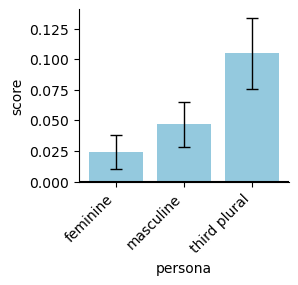

In [12]:
riveter.plot_scores(number_of_scores=10, 
                    title='', 
                    target_personas=['masculine', 'feminine', 'third plural'],
                    figsize=(3,3),
                    output_path='/Users/maria/Desktop/barplot.prideandprejudice.pronouns.pdf')

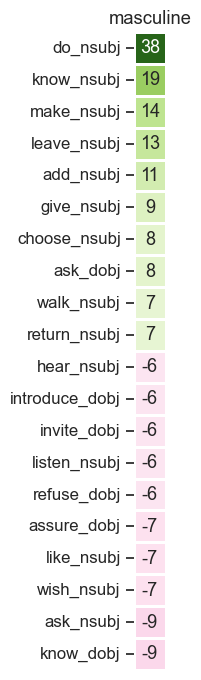

In [22]:
riveter.plot_verbs_for_persona('masculine', figsize=(3,7), output_path='/Users/maria/Desktop/heatmap.prideandprejudice.masculine.pdf')

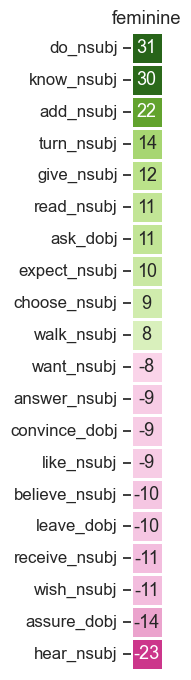

In [23]:
riveter.plot_verbs_for_persona('feminine', figsize=(3,7), output_path='/Users/maria/Desktop/heatmap.prideandprejudice.feminine.pdf')

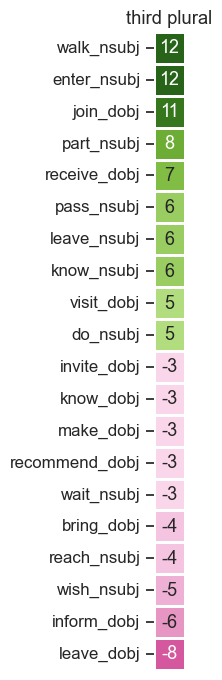

In [24]:
riveter.plot_verbs_for_persona('third plural', figsize=(3,7), output_path='/Users/maria/Desktop/heatmap.prideandprejudice.thirdplural.pdf')